# Text Classification with an RNN in 



Hi ! This notebook is part of a series in which I am trying t re-learn Deep Learning concepts I haven't used in a while. Currently, I am interested in Natural Language Processing. I figured I would start by implementing some basic TensorFlow code, in order to continue with more challenging models and datasets. 

The Pipeline I follow is the usual when using Keras and TF:

1. Setup of Libraries.
2. Download/ Access Raw Data.
3. Create a Text Encoder. This step allows to convert sentences of words into vector representations using tokenization. Some text-preprocessing is required in this step also.
4. Optimize the text dataset. Some cool features from TF re used to improve memory and optimization.
5. Create the Model. Some times this step will be directly from the TF 2.0 API, or simply using a Sequential model from Keras. A key aspect is necesary to notice. SInce we are working with vector representations of words, it is necesary to build embeddings. Embeeddings are tipically dense encodings of words. Ideally, similar words have similar encodings. 
6. Compile the model. Depending on the task, this step might get more complicated. For now, I will only use standard compilation parameters.
7. Train the model. This is done using Kaggle's GPU power. Thanks Kaggle!.
8. Some kind of inference about predicted data or model structure.

___


In this particular Notebook, the task at hand would be a simple Binary Classification problem using the imdb reviews dataset. The objective is to predict if the review was good or not.

## Setup

### Libraries

In [1]:
! pip install -q tensorflow_datasets

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Download Data

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBFEXMZ/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBFEXMZ/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBFEXMZ/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

An example of the data available

In [5]:
for example, label in train_dataset.take(1):
    print(f'Text: {example.numpy()} \n')
    print(f'Label: {label.numpy()} \n')
    print("---")

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." 

Label: 0 

---


### Dataset

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

An example of the dataset. It is clear that the data is vectorized now.

In [7]:
for example, label in train_dataset.take(1):
    print(f"Texts : {example.numpy()[:3]} \n")
    print(f"Labels: {label.numpy()[:3]} \n")
    print("----")

Texts : [b"Weaker entry in the Bulldog Drummond series, with John Howard in the role. Usual funny banter and antics, but not much plot. Barrymore gets something to do as the inspector, swapping disguises to follow Drummond, Algy, and Tenny on a wild goose chase (mostly in circles; perhaps the budget was tighter than usual) to rescue poor Phyllis, who is being held captive by people who want to lure Drummond to his doom. For those keeping score, in this one, Drummond is planning to ask Phyllis to marry him and Algy is worried about missing the baby's christening. It's fun to see Algy and Tenny dressed up as fisherman to blend in at The Angler's Rest, but little of it rises above silly."
 b"Brilliant film, the next best film to The Drunken Master (Jackie Chan). I recently bought it on an original VHS and i haven't seen this film for 15 years but still as good as it was back then. The acting was terrible and the dubbing was even worse but it those features that make this film (and many ot

## Text Encoder

Here we process raw train data into tokens.

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

Example of the first 20 words in the vocabulary.

In [9]:
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Notice that sentences have variable lengths. The TextVectorizers produces a 0 padding up to the maximum lngth available in the dataset.

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   8, ...,   0,   0,   0],
       [525,  20,   2, ...,   0,   0,   0],
       [527, 382,   2, ...,   0,   0,   0]])

An important thing to notice is that the vectorization is non biyective, since upper cases and punctuationss are removed. Additionally, the size of the vocabulary is small and hence some workds will be tokenized das Unknown by the TextVectorizer.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Weaker entry in the Bulldog Drummond series, with John Howard in the role. Usual funny banter and antics, but not much plot. Barrymore gets something to do as the inspector, swapping disguises to follow Drummond, Algy, and Tenny on a wild goose chase (mostly in circles; perhaps the budget was tighter than usual) to rescue poor Phyllis, who is being held captive by people who want to lure Drummond to his doom. For those keeping score, in this one, Drummond is planning to ask Phyllis to marry him and Algy is worried about missing the baby's christening. It's fun to see Algy and Tenny dressed up as fisherman to blend in at The Angler's Rest, but little of it rises above silly."
Round-trip:  [UNK] [UNK] in the [UNK] [UNK] series with john [UNK] in the role usual funny [UNK] and [UNK] but not much plot [UNK] gets something to do as the [UNK] [UNK] [UNK] to follow [UNK] [UNK] and [UNK] on a [UNK] [UNK] [UNK] mostly in [UNK] perhaps the budget was [UNK] than usual to [UNK] poor [

## Create a Model

We use a very simple model. The model is composed by five Layers in a Sequential flow. 



![](https://www.tensorflow.org/tutorials/text/images/bidirectional.png)



The TextVectorization and Embedding Layers have been explained. In the Bidirectional Layer, we use an RNN. This allows the input to be propagated in both forward and backward directions, generating two outputs that are concatenated at the end, and sent as input for a Dense layer and a final Classifier.

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

## Compile the Model

We compile the model. We use the Binary Crossentropy Loss since we are dealing with Binary Classification. We also use the Adam optmizer. We use a smaller learning rate.

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the Model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 38s 97ms/step - loss: 0.6325 - accuracy: 0.5796 - val_loss: 0.5354 - val_accuracy: 0.7036
Epoch 2/10
391/391 [==============================] - 35s 88ms/step - loss: 0.4363 - accuracy: 0.7909 - val_loss: 0.4109 - val_accuracy: 0.8052
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3594 - accuracy: 0.8405 - val_loss: 0.3661 - val_accuracy: 0.8375
Epoch 4/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3321 - accuracy: 0.8577 - val_loss: 0.3505 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 37s 94ms/step - loss: 0.3176 - accuracy: 0.8646 - val_loss: 0.3178 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 36s 91ms/step - loss: 0.3086 - accuracy: 0.8697 - val_loss: 0.2957 - val_accuracy: 0.8703
Epoch 7/10
391/391 [==============================] - 35s 89ms/step - loss: 0.3050 - accuracy: 0.8714 - val_loss: 0.3237 - val_accuracy:

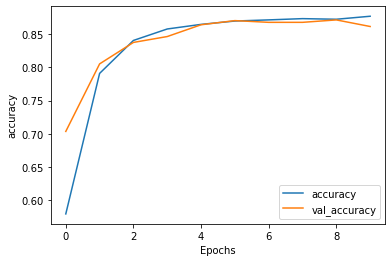

In [15]:
plot_graphs(history, "accuracy")

We achieve reazonable high validation accuracy, considering the vocabulary size and the number of epochs.

## Run a Simple Prediction

We run the model on a simple sentence. The output is a logit probability, and so we threshold in 0.0 for positive or negative review.

In [16]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.8703917]], dtype=float32)

The prediction is that the review is positive, which seems true. Nonetheless, the probability is very near the threshold. This might indicate that the model can be improved.

## Stacking two or more LSTM


Recurrent Layers have the option to return sequences. This means that the output for each neuron is returned, and not just the last one (a 2D tensor of shape (batch_size, output_feature)).

If we return the sequences, we obtain a 3D tensor of shape (batch_size, time_steps, output_features). This can be given as input for consective RNNs, since it has 3 axes as the input.

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

The rest of the training configuration is the same.

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

We now train the model with the same configuration as before.

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 67s 172ms/step - loss: 0.6242 - accuracy: 0.5959 - val_loss: 0.4697 - val_accuracy: 0.7719
Epoch 2/10
391/391 [==============================] - 63s 161ms/step - loss: 0.3971 - accuracy: 0.8273 - val_loss: 0.3578 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 63s 161ms/step - loss: 0.3461 - accuracy: 0.8517 - val_loss: 0.3805 - val_accuracy: 0.7911
Epoch 4/10
391/391 [==============================] - 63s 161ms/step - loss: 0.3250 - accuracy: 0.8615 - val_loss: 0.3175 - val_accuracy: 0.8651
Epoch 5/10
391/391 [==============================] - 63s 162ms/step - loss: 0.3177 - accuracy: 0.8645 - val_loss: 0.3193 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 63s 162ms/step - loss: 0.3095 - accuracy: 0.8682 - val_loss: 0.3233 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 63s 161ms/step - loss: 0.3081 - accuracy: 0.8678 - val_loss: 0.3064 - val_ac

We now plot the train and validation results. 

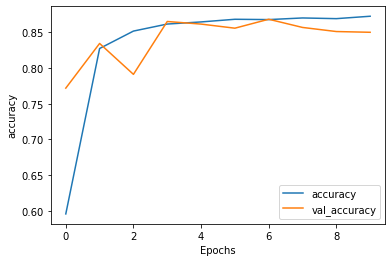

In [20]:
plot_graphs(history, "accuracy")

### Evaluation

We evaluate the model on the test set to obtain the best loss and accuracy values.

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 27s 68ms/step - loss: 0.3167 - accuracy: 0.8596
Test Loss: 0.3167353570461273
Test Accuracy: 0.8596000075340271


Finally, we make a prediction on a simple sentence:

In [22]:
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.013717]]


In [23]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.49728838]], dtype=float32)

The model acctually did not improve much the performance. One 